# Image Processing

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import random
import matplotlib.pyplot as plt
import numpy as np
from torch import optim
from torch.optim import lr_scheduler
import torchvision.models as models

# ----------------------------------------------------------------------------------------------
# Augmentation
# Define data augmentation transforms
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),  # Randomly rotate the image up to 30 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Adjust color
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random affine transformation
    transforms.RandomPerspective(),  # Random perspective transformation
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random resized crop
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image to RGB
])

dataset = ImageFolder(root='/local/data1/honzh073/data/8bit_patient', transform=transform)

# ----------------------------------------------------------------------------------------------
# Random seed
seed = 123
random.seed(seed)
torch.manual_seed(seed)

# Split dataset into 80% train, 10% validation, and 10% test
total_size = len(dataset)
train_size = int(0.8 * total_size)
validation_size = int(0.1 * total_size)
test_size = total_size - train_size - validation_size

train_dataset, validation_dataset, test_dataset = random_split(
    dataset, [train_size, validation_size, test_size], generator=torch.Generator().manual_seed(seed)
)

# DataLoader for training, validation, and testing
batch_size = 64

# Move data loaders to GPU if available
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

# ----------------------------------------------------------------------------------------------
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available!")
    device = torch.device("cuda:1")  # Use GPU 0
else:
    print("CUDA is not available.")
    device = torch.device("cpu")
# ----------------------------------------------------------------------------------------------
print('done!')


CUDA is available!
done!


# Plot 8 bit Images

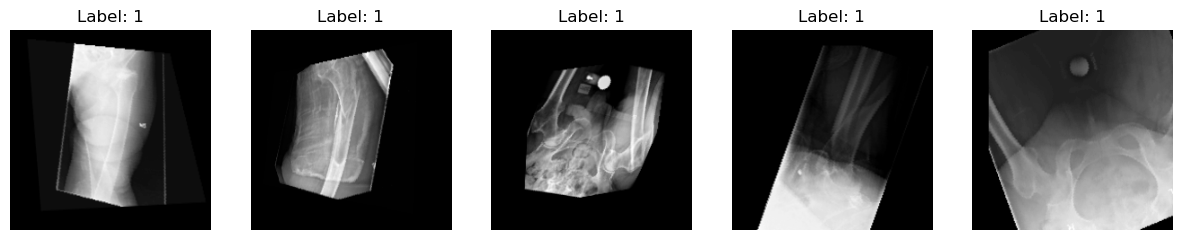

In [2]:
# ---------------------------------------------------------------------------------
# Get some random indices from the training dataset
random_indices = np.random.choice(len(validation_dataset), 5, replace=False)

# Plot images (transformed)
plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_indices):
    image, label = train_dataset[idx]
    plt.subplot(1, 5, i + 1)
    plt.title(f"Label: {label}")
    # plt.imshow(image[0])  # 3-channel (RGB)
    plt.imshow(image[0], cmap='gray')  #single-channel (grayscale)
    plt.axis('off')
plt.show()


# Class weights of Training Dataset

In [3]:
# ---------------------------------------------------------------------------------
# aff and nff numbers in training dataset
train_aff_count = sum(1 for _, label in train_dataset if label == 0)  # 0 AFF
train_nff_count = sum(1 for _, label in train_dataset if label == 1)  # 1 NFF

# aff and nff numbers in test dataset
valid_aff_count = sum(1 for _, label in validation_dataset if label == 0)
valid_nff_count = sum(1 for _, label in validation_dataset if label == 1)

# aff and nff numbers in test dataset
test_aff_count = sum(1 for _, label in test_dataset if label == 0)
test_nff_count = sum(1 for _, label in test_dataset if label == 1)

print(f"train aff number: {train_aff_count}")
print(f"train nff number: {train_nff_count}")
print(f"validation aff number: {valid_aff_count}")
print(f"validation nff number: {valid_nff_count}")
print(f"test aff number: {test_aff_count}")
print(f"test nff number: {test_nff_count}")

# ---------------------------------------------------------------------------------
# Calculate class weights
n_aff_train = train_aff_count
n_nff_train = train_nff_count

class_weight_aff = 1 / (2 * (n_aff_train / (n_aff_train + n_nff_train)))
class_weight_nff = 1 / (2 * (n_nff_train / (n_aff_train + n_nff_train)))

print(f"Class Weight for AFF (0): {class_weight_aff:.4f}")
print(f"Class Weight for NFF (1): {class_weight_nff:.4f}")


train aff number: 689
train nff number: 2784
validation aff number: 87
validation nff number: 347
test aff number: 92
test nff number: 343
Class Weight for AFF (0): 2.5203
Class Weight for NFF (1): 0.6237


# ResNet152
# 80% Training, 10% Validation, and 10% Test
# Test Performance

Epoch 1/30, Train Loss: 0.6735, Validation Loss: 0.6647, Train Acc: 65.76%, Validation Acc: 64.75%
Epoch 2/30, Train Loss: 0.5155, Validation Loss: 0.5536, Train Acc: 71.41%, Validation Acc: 78.80%
Epoch 3/30, Train Loss: 0.4438, Validation Loss: 0.5284, Train Acc: 78.03%, Validation Acc: 73.73%
Epoch 4/30, Train Loss: 0.6431, Validation Loss: 0.5433, Train Acc: 82.15%, Validation Acc: 81.80%
Epoch 5/30, Train Loss: 0.3576, Validation Loss: 0.4270, Train Acc: 83.04%, Validation Acc: 80.65%
Epoch 6/30, Train Loss: 0.3109, Validation Loss: 0.4329, Train Acc: 84.19%, Validation Acc: 83.41%
Epoch 7/30, Train Loss: 0.3779, Validation Loss: 0.4493, Train Acc: 84.45%, Validation Acc: 84.79%
Epoch 8/30, Train Loss: 0.3399, Validation Loss: 0.4268, Train Acc: 86.01%, Validation Acc: 84.10%
Epoch 9/30, Train Loss: 0.2790, Validation Loss: 0.3549, Train Acc: 87.59%, Validation Acc: 81.80%
Epoch 10/30, Train Loss: 0.2230, Validation Loss: 0.3327, Train Acc: 87.62%, Validation Acc: 90.32%
Epoch 11/

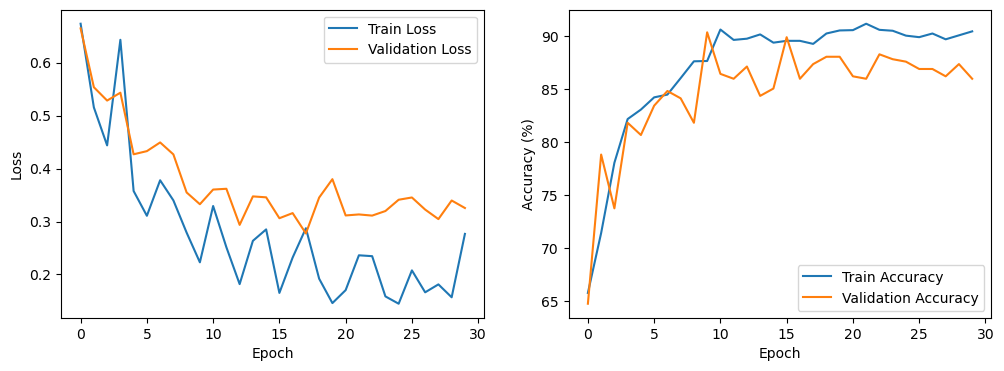

Test Loss: 0.2970, Test Acc: 88.74%


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

# Settings
lr = 0.0001
step_size = 10
gamma = 0.1

# Class weights
class_weights = [class_weight_aff, class_weight_nff]
class_weights = torch.Tensor(class_weights).to(device)

# ResNet152
model = models.resnet152(pretrained=True)
# Modify the final fully connected (fc) layer to match the number of classes in your dataset
num_classes = 2  # Assuming 2 classes (you can adjust this)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Load trained model's weights
checkpoint = torch.load('/local/data1/honzh073/saved_model/fracatlas.pth')
model.load_state_dict(checkpoint)  # Load the model's state_dict directly

# Loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Training (loss and accuracy)
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = 100 * correct_train / total_train
    
    model.eval()
    correct_validation = 0
    total_validation = 0
    validation_loss = 0
    
    with torch.no_grad():
        for images, labels in validation_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            _, predicted = torch.max(outputs.data, 1)
            total_validation += labels.size(0)
            correct_validation += (predicted == labels).sum().item()
            validation_loss += loss.item()
    
    validation_accuracy = 100 * correct_validation / total_validation
    validation_loss /= len(validation_loader)
    
    train_losses.append(loss.item())
    validation_losses.append(validation_loss)
    train_accuracies.append(train_accuracy)
    validation_accuracies.append(validation_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Validation Loss: {validation_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Validation Acc: {validation_accuracy:.2f}%")
    
    scheduler.step()  # Step the learning rate scheduler

# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# Test dataset performance
model.eval()
correct_test = 0
total_test = 0
test_loss = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        test_loss += loss.item()

test_accuracy = 100 * correct_test / total_test
test_loss /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")


In [7]:
from sklearn.metrics import confusion_matrix, classification_report

# 获取原始数据集的类别标签
original_classes = train_loader.dataset.dataset.classes

# 计算混淆矩阵和分类报告
with torch.no_grad():
    all_predictions = []
    all_labels = []

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 生成混淆矩阵
conf_matrix = confusion_matrix(all_labels, all_predictions)

# 计算 Precision、Recall、F1 Score
classification_rep = classification_report(all_labels, all_predictions, target_names=original_classes)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)
# 85 AFF 350 NFF

Confusion Matrix:
[[ 80  12]
 [ 32 311]]
Classification Report:
              precision    recall  f1-score   support

         AFF       0.71      0.87      0.78        92
         NFF       0.96      0.91      0.93       343

    accuracy                           0.90       435
   macro avg       0.84      0.89      0.86       435
weighted avg       0.91      0.90      0.90       435



# Save model

In [7]:
# Save the trained VGG model
# torch.save(model.state_dict(), 'transfer_patient_level_resnet152.pth')


# Clean GPU memory

In [8]:
torch.cuda.empty_cache()


# VGG19